In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
plt.rcParams["figure.dpi"] = 130


In [2]:
def save_run_npz(save_path, y_true, y_pred, classes, test_loss=None, test_acc=None):
    """Persist a model's evaluation so we can compare apples-to-apples later."""
    classes = np.array(list(classes), dtype=object)
    if test_acc is None:
        test_acc = (np.asarray(y_true) == np.asarray(y_pred)).mean()
    np.savez_compressed(
        save_path,
        classes=classes,
        y_true=np.asarray(y_true),
        y_pred=np.asarray(y_pred),
        test_loss=(None if test_loss is None else float(test_loss)),
        test_acc=float(test_acc),
    )
    print(f"Saved → {save_path}")


In [ ]:
# Example only — replace these with your actual MFCC arrays/labels:
# y_true_mfcc, y_pred_mfcc, classes_mfcc = y_true, y_pred, encoder.categories_[0]
# Optionally: test_loss_mfcc, test_acc_mfcc = test_loss, test_acc

# save_run_npz("mfcc_baseline_results.npz", y_true_mfcc, y_pred_mfcc, classes_mfcc, test_loss_mfcc, test_acc_mfcc)


In [11]:
import numpy as np

def load_results_npz(path):
    arr = np.load(path, allow_pickle=True)
    files = set(arr.files)

    # Accept common variants
    key_aliases = {
        "classes":  ["classes", "class_names", "label_names", "labels"],
        "y_true":   ["y_true", "ytest", "y_test", "true_idx", "targets", "test_targets"],
        "y_pred":   ["y_pred", "ypred", "y_pred_idx", "pred_idx", "preds", "logits", "probs"],
        "test_loss":["test_loss", "loss", "testloss"],
        "test_acc": ["test_acc", "accuracy", "acc", "test_accuracy"],
    }

    out = {}
    for std, alts in key_aliases.items():
        for k in alts:
            if k in files:
                out[std] = arr[k]
                break

    # If y_true truly missing, try to reconstruct from saved split labels (strings)
    if "y_true" not in out:
        try:
            splits = np.load("common_splits_4cls.npz", allow_pickle=True)
            if "y_test" in splits.files and "classes" in out:
                y_test_labels = splits["y_test"]  # strings like 'angry','happy',...
                classes = list(np.array(out["classes"]).tolist())
                out["y_true"] = np.array([classes.index(lbl) for lbl in y_test_labels], dtype=int)
                print(f"[{path}] Reconstructed y_true from common_splits_4cls.npz")
        except FileNotFoundError:
            pass

    # Hard requirements now
    missing = [k for k in ("classes","y_pred","y_true") if k not in out]
    if missing:
        raise KeyError(f"{path} missing {missing}. Has: {sorted(files)}")

    # Normalize shapes/types
    out["classes"] = list(np.array(out["classes"]).tolist())

    # y_pred: if probs/logits, argmax
    ypred = np.asarray(out["y_pred"])
    if ypred.ndim == 2 and ypred.shape[1] > 1:
        ypred = ypred.argmax(axis=1)
    out["y_pred"] = ypred.astype(int).ravel()

    out["y_true"] = np.asarray(out["y_true"]).astype(int).ravel()

    # Optional scalars
    out["test_loss"] = float(out.get("test_loss", np.nan))
    out["test_acc"]  = float(out.get("test_acc",  np.nan))
    return out

# --- Use it ---
mel  = load_results_npz("../cached_data/mel_baseline_results_7cls.npz")   # or _7cls if that’s what you ran
mfcc = load_results_npz("../cached_data/mfcc_baseline_results.npz")


In [15]:
# --- Prep: load MFCC + Mel results and align classes ---
import numpy as np, pandas as pd

def load_results_npz(path):
    arr = np.load(path, allow_pickle=True)
    files = set(arr.files)

    def pick(*names):
        for n in names:
            if n in files:
                return arr[n]
        return None

    classes = pick("classes","class_names","labels")
    if classes is None:
        raise KeyError(f"{path} missing 'classes'. Has: {sorted(files)}")
    classes = list(np.array(classes).tolist())

    y_true = pick("y_true","y_test","true_idx","targets")
    y_pred = pick("y_pred","ypred","pred_idx","preds","logits","probs")

    if y_true is None or y_pred is None:
        raise KeyError(f"{path} missing y_true/y_pred. Has: {sorted(files)}")

    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    # If predictions are logits/probs, convert to indices
    if y_pred.ndim == 2 and y_pred.shape[1] > 1:
        y_pred = y_pred.argmax(axis=1)

    return dict(classes=classes,
                y_true=y_true.astype(int).ravel(),
                y_pred=y_pred.astype(int).ravel())

# --- Set your files (pick 4cls or 7cls consistently for BOTH) ---
mfcc_path = f"../cached_data/mfcc_baseline_results.npz"
mel_path  = f"../cached_data/mel_baseline_results_7cls.npz"

mfcc = load_results_npz(mfcc_path)
mel  = load_results_npz(mel_path)

# --- Ensure class sets match, and remap Mel indices into MFCC class order if needed ---
classes_mfcc = mfcc["classes"]
classes_mel  = mel["classes"]

if set(classes_mfcc) != set(classes_mel):
    raise ValueError(f"Class sets differ:\nMFCC: {classes_mfcc}\nMel:  {classes_mel}")

# Build index map from Mel's order -> MFCC's order
if classes_mfcc != classes_mel:
    idx_map = {classes_mel.index(c): classes_mfcc.index(c) for c in classes_mel}
    remap = np.array([idx_map[i] for i in range(len(classes_mel))])
    y_true_mel = remap[mel["y_true"]]
    y_pred_mel = remap[mel["y_pred"]]
else:
    y_true_mel = mel["y_true"]
    y_pred_mel = mel["y_pred"]

# Expose unified variables for your summarize() call
classes     = classes_mfcc
y_true_mfcc = mfcc["y_true"]
y_pred_mfcc = mfcc["y_pred"]


In [16]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def summarize(y_true, y_pred, labels):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, support = precision_recall_fscore_support(
        y_true, y_pred,
        labels=range(len(labels)),
        zero_division=0
    )
    macro = dict(
        accuracy = acc,
        precision = prec.mean(),
        recall = rec.mean(),
        f1 = f1.mean(),
        samples = int(support.sum())
    )
    per_class = pd.DataFrame({
        "class": labels,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "support": support
    })
    return macro, per_class

mfcc_macro, mfcc_cls = summarize(y_true_mfcc, y_pred_mfcc, classes)
mel_macro,  mel_cls  = summarize(y_true_mel,  y_pred_mel,  classes)

overall = pd.DataFrame([
    {"Model":"MFCC", **mfcc_macro},
    {"Model":"Mel",  **mel_macro},
])[["Model","accuracy","precision","recall","f1","samples"]].round(4)

per_class = (
    pd.concat([mfcc_cls.assign(Model="MFCC"), mel_cls.assign(Model="Mel")], ignore_index=True)
      .pivot(index="class", columns="Model", values=["precision","recall","f1","support"])
      .round(4)
)

overall, per_class


(  Model  accuracy  precision  recall      f1  samples
 0  MFCC    0.9815     0.9826  0.9823  0.9824    13122
 1   Mel    0.7931     0.8024  0.8054  0.8032     3281,
          precision          recall              f1         support       
 Model         MFCC     Mel    MFCC     Mel    MFCC     Mel    MFCC    Mel
 class                                                                    
 angry       0.9881  0.8434  0.9833  0.8350  0.9857  0.8392  2031.0  503.0
 disgust     0.9784  0.7456  0.9784  0.7575  0.9784  0.7515  1995.0  503.0
 fear        0.9738  0.7148  0.9685  0.7575  0.9712  0.7355  1999.0  503.0
 happy       0.9737  0.7843  0.9845  0.7734  0.9791  0.7788  2069.0  503.0
 neutral     0.9851  0.8204  0.9826  0.8569  0.9839  0.8382  2015.0  517.0
 sad         0.9828  0.7851  0.9857  0.6899  0.9843  0.7344  2030.0  503.0
 surprise    0.9959  0.9234  0.9929  0.9679  0.9944  0.9451   983.0  249.0)

In [17]:
from IPython.display import display
print("== Overall metrics ==")
display(overall.style.format({"accuracy":"{:.3f}","precision":"{:.3f}","recall":"{:.3f}","f1":"{:.3f}"}))

print("\n== Per-class metrics ==")
display(per_class.style.format("{:.3f}"))


== Overall metrics ==


,Model,accuracy,precision,recall,f1,samples
0,MFCC,0.982,0.983,0.982,0.982,13122
1,Mel,0.793,0.802,0.805,0.803,3281



== Per-class metrics ==


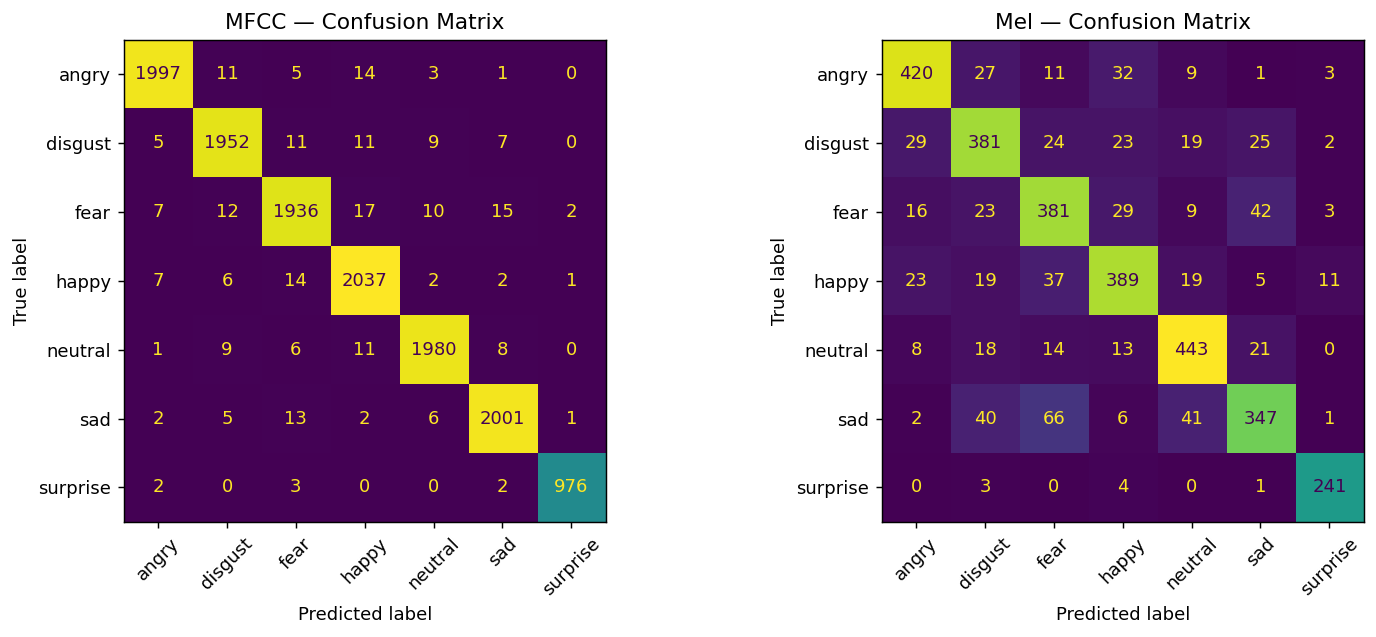

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_mfcc = confusion_matrix(y_true_mfcc, y_pred_mfcc, labels=range(len(classes)))
cm_mel  = confusion_matrix(y_true_mel,  y_pred_mel,  labels=range(len(classes)))

disp1 = ConfusionMatrixDisplay(cm_mfcc, display_labels=classes)
disp1.plot(ax=axes[0], colorbar=False, xticks_rotation=45)
axes[0].set_title("MFCC — Confusion Matrix")

disp2 = ConfusionMatrixDisplay(cm_mel, display_labels=classes)
disp2.plot(ax=axes[1], colorbar=False, xticks_rotation=45)
axes[1].set_title("Mel — Confusion Matrix")

plt.tight_layout()
plt.show()


In [19]:
# Overall
overall.to_csv("mfcc_vs_mel_overall.csv", index=False)
# Per-class (flatten MultiIndex columns)
flat_cols = ["_".join(col).strip("_") for col in per_class.columns.values]
per_class_out = per_class.copy()
per_class_out.columns = flat_cols
per_class_out.to_csv("mfcc_vs_mel_per_class.csv")
print("Wrote: mfcc_vs_mel_overall.csv, mfcc_vs_mel_per_class.csv")


Wrote: mfcc_vs_mel_overall.csv, mfcc_vs_mel_per_class.csv
